In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = (
"cuda"
if torch.cuda.is_available()
else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
image_folder_path = "C:\\Users\\sauryan\\Downloads\\train_images (PneumonialMNIST).npy"
label_folder_path = "C:\\Users\\sauryan\\Downloads\\train_labels (PneumonialMNIST).npy"
y = np.load(label_folder_path)
y = torch.from_numpy(y).to(device)
print(y.shape)

torch.Size([2682])


In [22]:
x_train = np.load(image_folder_path)
'''batch_size = 32
resized_images = []

for i in range(0, len(x_train), batch_size):
    batch = x_train[i:i + batch_size]
    batch_resized = []

    for image in batch:
        pil_img = Image.fromarray(image)
        resized_image = pil_img.resize((112, 112))
        batch_resized.append(np.array(resized_image))

    resized_images.extend(batch_resized)

resized_data = np.array(resized_images)'''
x_train = torch.from_numpy(resized_data).to(device)
print(x_train.shape)

torch.Size([2682, 112, 112, 3])


In [5]:
dataset = TensorDataset(x_train, y)

In [6]:
batch_size = 8
train_set = DataLoader(dataset, batch_size=batch_size, shuffle=True)

tensor([[[[ 28,  28,  28],
          [ 28,  28,  28],
          [ 25,  25,  25],
          ...,
          [ 27,  27,  27],
          [ 25,  25,  25],
          [ 28,  28,  28]],

         [[ 27,  27,  27],
          [ 21,  21,  21],
          [ 20,  20,  20],
          ...,
          [ 23,  23,  23],
          [ 25,  25,  25],
          [ 28,  28,  28]],

         [[ 23,  23,  23],
          [ 16,  16,  16],
          [ 28,  28,  28],
          ...,
          [ 18,  18,  18],
          [ 24,  24,  24],
          [ 26,  26,  26]],

         ...,

         [[ 43,  43,  43],
          [ 43,  43,  43],
          [ 41,  41,  41],
          ...,
          [ 43,  43,  43],
          [ 34,  34,  34],
          [ 34,  34,  34]],

         [[ 43,  43,  43],
          [ 43,  43,  43],
          [ 41,  41,  41],
          ...,
          [ 33,  33,  33],
          [ 29,  29,  29],
          [ 34,  34,  34]],

         [[ 43,  43,  43],
          [ 43,  43,  43],
          [ 41,  41,  41],
         

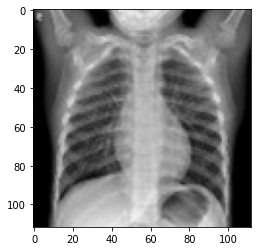

Label: 0


In [7]:
train_features, train_labels = next(iter(train_set))
print(train_features, train_labels)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[3].squeeze().cpu()
label = train_labels[3].cpu()
print(img.size(), label)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [9]:
img_height = x_train.shape[1] #
img_width = x_train.shape[2] #
num_channels = x_train.shape[3] # 3
input_shape = (img_height, img_width, num_channels) # (,3)
latent_dim = 2500 # Dimension of the latent space

In [10]:
class Encoder(nn.Module):
  def __init__(self, input_shape, latent_dim):
    super().__init__()

    self.encoder_conv = nn.Sequential(
         nn.Conv2d(in_channels = input_shape[2], out_channels = 8, kernel_size = 5, stride = 2, padding = 1),
         nn.ReLU(),
         nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 5, stride = 2, padding = 1),
         nn.ReLU(),
         nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 1),
         nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.mu = nn.Linear(32 * (input_shape[0] // 8 - 1) * (input_shape[1] // 8 - 1), latent_dim)
    self.sigma = nn.Linear(32 * (input_shape[0] // 8 - 1) * (input_shape[1] // 8 - 1), latent_dim)

  def forward(self, x):
    x = self.encoder_conv(x)
    x = self.flatten(x)
    mu = self.mu(x)
    sigma = self.sigma(x)
    return mu, sigma

In [11]:
encoder = Encoder(input_shape, latent_dim).to(device)
print(encoder)

Encoder(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=5408, out_features=2500, bias=True)
  (sigma): Linear(in_features=5408, out_features=2500, bias=True)
)


In [12]:
class Reparameterize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mu, sigma = x
        batch, dim = mu.size()
        eps = torch.randn((batch, dim), device=mu.device)
        return mu + torch.exp(sigma / 2) * eps

In [13]:
class Decoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 32 * (input_shape[0] // 8 - 1) * (input_shape[1] // 8 - 1))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=input_shape[2], kernel_size=5, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 32, (self.input_shape[0] // 8 - 1), (self.input_shape[1] // 8 - 1))
        x = self.decoder_conv(x)
        return x

In [14]:
decoder = Decoder(input_shape, latent_dim).to(device)
print(decoder)

Decoder(
  (fc): Linear(in_features=2500, out_features=5408, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 3, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [15]:
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = Encoder(self.input_shape, self.latent_dim)
        self.decoder = Decoder(self.input_shape, self.latent_dim)
        self.reparameterize = Reparameterize()

    def forward(self, x):
        mu, sigma = self.encoder(x.to(device))
        latent_space = self.reparameterize((mu, sigma))
        reconstruction = self.decoder(latent_space)

        return reconstruction, mu, sigma

    def kl_divergence_loss(self, mu, sigma):
        kl_loss = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        return kl_loss

    def reconstruction_loss(self, output, target):
        recon_loss = nn.functional.mse_loss(output, target, reduction='sum')
        return recon_loss

    def kl_reconstruction_loss(self, output, target, mu, sigma):
        recon_loss = self.reconstruction_loss(output, target)
        kl_loss = self.kl_divergence_loss(mu, sigma)
        vae_loss = (recon_loss + kl_loss)
        return vae_loss

In [16]:
vae = VAE(input_shape, latent_dim).to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (encoder_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mu): Linear(in_features=5408, out_features=2500, bias=True)
    (sigma): Linear(in_features=5408, out_features=2500, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2500, out_features=5408, bias=True)
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(8, 3, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
      (5): Sigmoid()
    )
  )
  (reparameterize): Reparam

In [17]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2, weight_decay=1e-5)
loss_fn = vae.kl_reconstruction_loss

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        tensor_list = []

        for i in range(len(y)):
            with torch.no_grad():
                tensor = (x[i] - torch.min(x[i])) / (torch.max(x[i]) - torch.min(x[i]))
                X = tensor.clone()
                X = X.permute(2, 0, 1).unsqueeze(0).float()
                tensor_list.append(X)

        combined_tensor = torch.stack(tensor_list, dim=0)
        final_tensor = torch.squeeze(combined_tensor, dim=1)

        pred, mu, sigma = vae(final_tensor.to(device))
        target = final_tensor[:, :, :pred.size(2), :pred.size(3)]

        loss = loss_fn(pred, target, mu, sigma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 24 == 0:
            loss_value, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss_value:>7f} [{current:>5d}/{size:>5d}]")

In [20]:
epochs = 5000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_set, vae, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 10648.032227 [    8/ 2682]
loss: 9491.049805 [  200/ 2682]
loss: 8280.474609 [  392/ 2682]
loss: 8924.005859 [  584/ 2682]
loss: 8806.346680 [  776/ 2682]
loss: 9960.934570 [  968/ 2682]
loss: 9982.532227 [ 1160/ 2682]
loss: 8603.816406 [ 1352/ 2682]
loss: 8557.763672 [ 1544/ 2682]
loss: 9805.773438 [ 1736/ 2682]
loss: 10071.523438 [ 1928/ 2682]
loss: 8156.337891 [ 2120/ 2682]
loss: 10023.907227 [ 2312/ 2682]
loss: 7773.768066 [ 2504/ 2682]
Epoch 2
-------------------------------
loss: 8690.245117 [    8/ 2682]
loss: 11226.626953 [  200/ 2682]
loss: 8754.646484 [  392/ 2682]
loss: 9198.902344 [  584/ 2682]
loss: 10511.662109 [  776/ 2682]
loss: 10019.887695 [  968/ 2682]
loss: 11379.048828 [ 1160/ 2682]
loss: 8031.831055 [ 1352/ 2682]
loss: 14034.153320 [ 1544/ 2682]
loss: 8909.694336 [ 1736/ 2682]
loss: 8714.979492 [ 1928/ 2682]
loss: 9815.373047 [ 2120/ 2682]
loss: 8153.986328 [ 2312/ 2682]
loss: 7827.246094 [ 2504/ 2682]
Epoch 3
--------

In [21]:
def generate_images_from_latent_space(vae, num_samples):
    # Generate random samples from a standard normal distribution
    latent_samples = torch.randn(num_samples, latent_dim)

    # Move the latent samples to the same device as the VAE model
    device = next(vae.parameters()).device
    latent_samples = latent_samples.to(device)

    # Pass latent samples through the decoder network
    with torch.no_grad():
        generated_images = vae.decoder(latent_samples)

    return generated_images


# Set the number of samples and the desired latent dimension
num_samples = 16

vae = vae.to('cuda:0')  # Move the VAE model to the GPU if available

generated_images = generate_images_from_latent_space(vae, num_samples)


def display_images(images):
    for i, image in enumerate(images):
        # Move the image tensor to CPU before converting to a numpy array
        image = image.cpu()

        # Convert the tensor image to a numpy array and transpose the dimensions
        image = np.transpose(image.detach().numpy(), (1, 2, 0))

        # Create a PIL image from the numpy array
        image = Image.fromarray((image * 255).astype(np.uint8))

        # Display the image
        image.show()


display_images(generated_images)

torch.Size([16, 3, 111, 111])
